# Mobile money transactions Fraud Detection
Author: https://github.com/elangovana/PaySim-Synthetic-Dataset-Fraud-Detection/tree/master
**Acknowledgements: This dataset is from Kaggle.
For details, see https://www.kaggle.com/ntnu-testimon/paysim1/home**

- [About this dataset](#About-this-dataset)
- [Before you start](#Before-you-start)
- [Setup](#Setup)
- [Data Processing](#Data-Processing)
  * [Load](#Load-data)
  * [Explore](#Explore-the-dataset)
  * [Feature Engineering](#Feature-Engineering)
  * [Prepare dataset for SageMaker XGBoost](#Prepare-dataset-for-SageMaker-XGBoost)
- [Training the XGBoost model](#Training-the-XGBoost-model)
- [Predict Using Batch transform](#Predict-Using-Batch-transform)
- [Predict using API inference endpoint](#Predict-using-API-inference-endpoint)



  


## About this dataset


There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.
Content

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

### Headers

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
Past Research

There are 5 similar files that contain the run of 5 different scenarios. These files are better explained at my PhD thesis chapter 7 (PhD Thesis Available here http://urn.kb.se/resolve?urn=urn:nbn:se:bth-12932).

We ran PaySim several times using random seeds for 744 steps, representing each hour of one month of real time, which matches the original logs. Each run took around 45 minutes on an i7 intel processor with 16GB of RAM. The final result of a run contains approximately 24 million of financial records divided into the 5 types of categories: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

### Acknowledgements

This work is part of the research project ”Scalable resource-efficient systems for big data analytics” funded by the Knowledge Foundation (grant: 20140032) in Sweden.

Please refer to this dataset using the following citations:

PaySim first paper of the simulator:

E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016



## Before you start
1. Manually Download the dataset from Kaggle https://www.kaggle.com/ntnu-testimon/paysim1/downloads/PS_20174392719_1491204439457_log.csv/2 and upload to s3

## Setup

In [17]:
### Download data from S3

#Enter the location of the input dataset uploaded from kaggle
## Say. s3://mybucket/PaySimFraudDetection>/PS_20174392719_1491204439457_log.csv.zip
s3_source_data="s3://mlops-bucket.store.nus.cloud"

##Results
bucket="mlops-bucket"
prefix="DemoPaySimFraudDetection"
bucket_prefix="{}/{}".format(bucket,prefix)
tmpdir="./tmpDemoPaySimFraudDetection"



In [20]:
import os
#local_input_zip=os.path.join(tmpdir, "paysim.zip")

#!aws s3 cp $s3_source_data $local_input_zip

In [21]:
#!unzip -o $local_input_zip -d $tmpdir

## Data Processing

### Load data
Load the csv file into pandas

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load the data into pandas

In [23]:
raw_data = "../data/paysim_data.csv"
data = pd.read_csv(raw_data)

### Explore the dataset 

In [24]:
data.head(n=10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [25]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


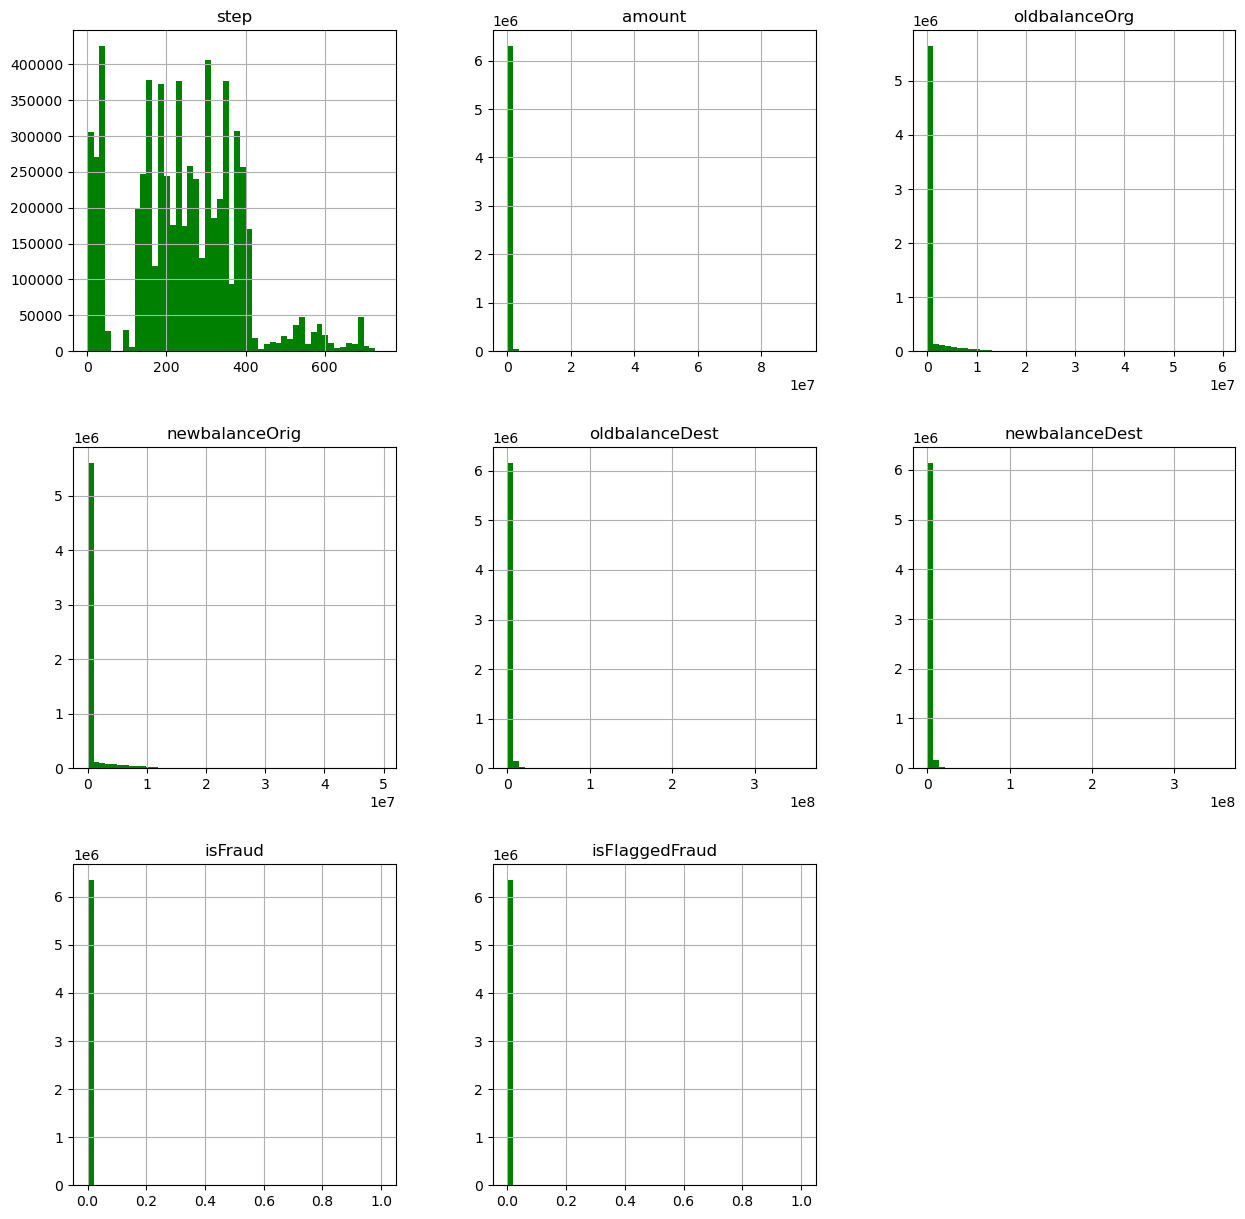

In [26]:
data.hist (bins=50, figsize=(15,15), color = 'green')
plt.show()

Distribution of transactions wrt to source account

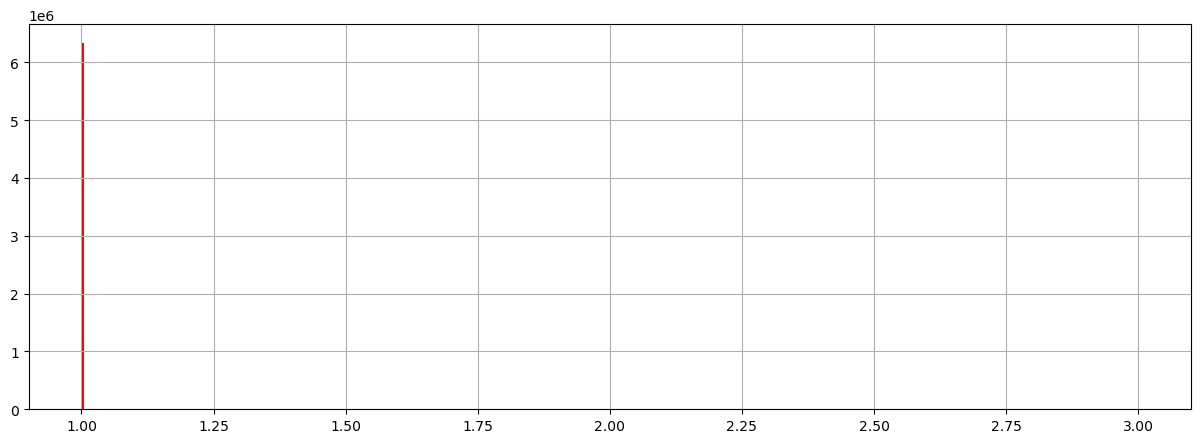

In [27]:
data['nameOrig'].value_counts().hist (bins=500, figsize=(15,5), color = 'red')
plt.show()

In [28]:
data['nameOrig'].value_counts().describe()

count    6.353307e+06
mean     1.001466e+00
std      3.832002e-02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.000000e+00
Name: count, dtype: float64

Distribution of transactions wrt to dest account

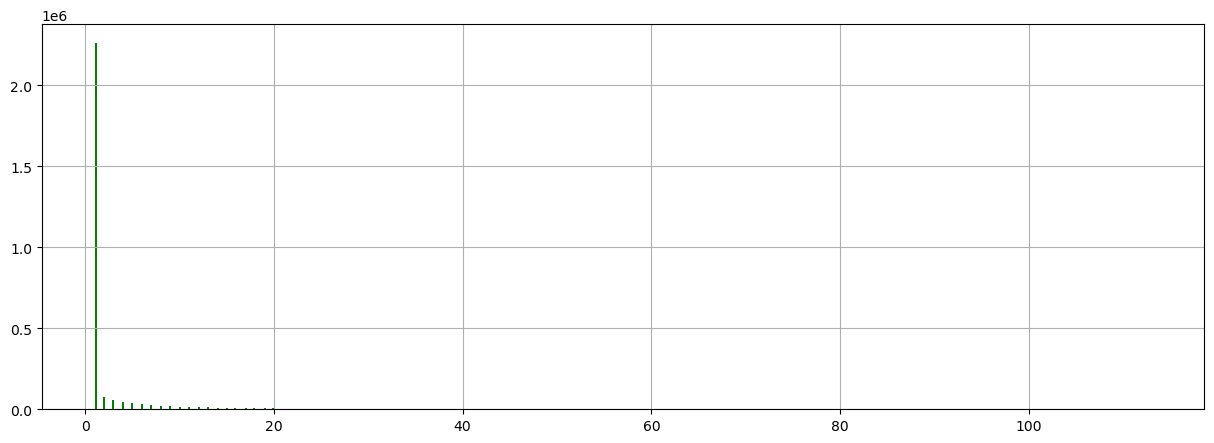

In [29]:
data['nameDest'].value_counts().hist (bins=500, figsize=(15,5), color = 'green')
plt.show()

In [30]:
data.sort_values(by=['step', 'nameOrig']).head(n=20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2332,1,DEBIT,2655.04,C10001825,21214.00,18558.96,C1850180796,1116396.05,1268668.92,0,0
1421,1,PAYMENT,2444.49,C1002041276,31454.00,29009.51,M485475507,0.00,0.00,0,0
1956,1,PAYMENT,1246.74,C1002911155,1468.00,221.26,M1467977993,0.00,0.00,0,0
100,1,PAYMENT,871.75,C1003206025,19869.00,18997.25,M989889899,0.00,0.00,0,0
2200,1,PAYMENT,264.93,C1003307628,0.00,0.00,M1595188851,0.00,0.00,0,0
247,1,PAYMENT,9029.12,C1003755748,25480.00,16450.88,M1414013111,0.00,0.00,0,0
994,1,PAYMENT,1617.90,C1004430079,507865.00,506247.10,M1379148981,0.00,0.00,0,0
883,1,CASH_OUT,59390.46,C100445376,0.00,0.00,C977993101,73791.34,965870.05,0,0
1007,1,PAYMENT,1213.64,C1006624255,86078.00,84864.36,M1721180011,0.00,0.00,0,0
1297,1,CASH_IN,377287.80,C100708535,5110945.41,5488233.21,C985934102,2256095.33,971418.91,0,0


Explore the class distribution

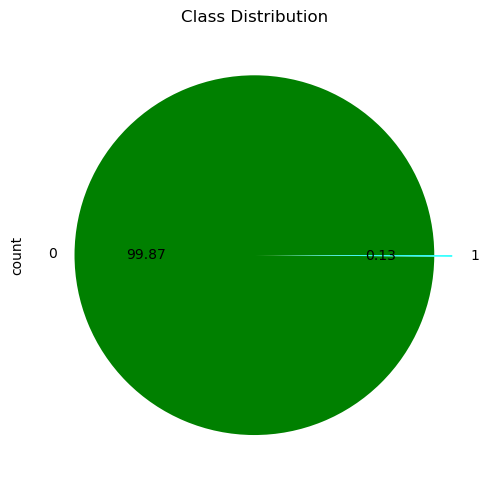

In [31]:
data.isFraud.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5), colors=["green","cyan"], explode=[0,.1])
plt.title('Class Distribution')
plt.tight_layout()

#### Highly imbalanced dataset
Since this is a highly imbalanced dataset, use AUCPR instead of AUC under ROC as the eval metric

View Correlation heatmap

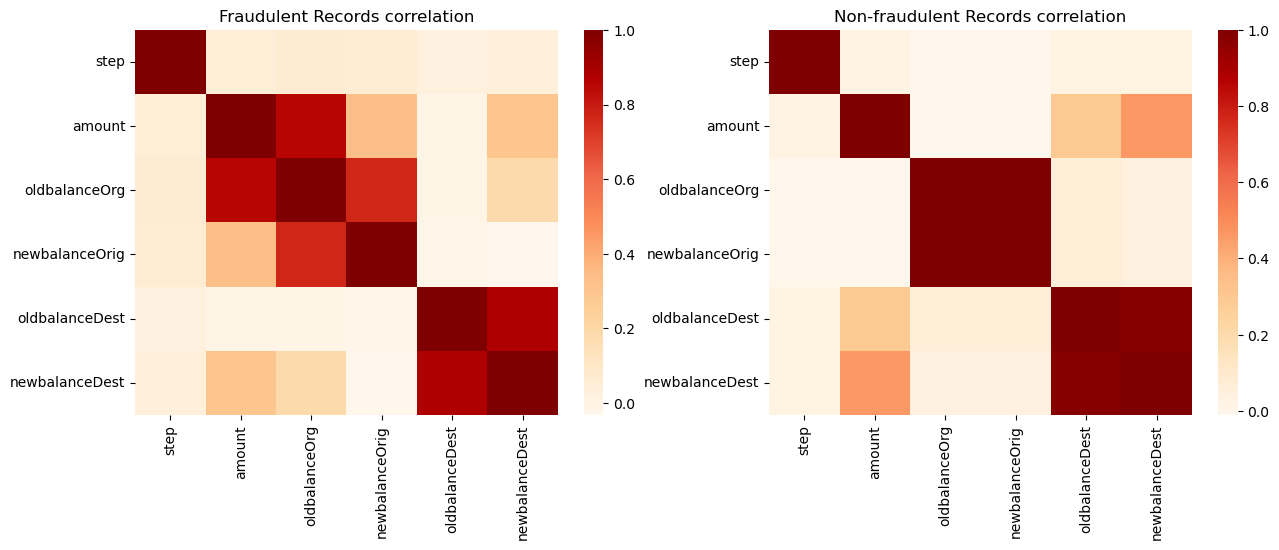

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Fraudulent records
fraud_df = data.query('isFraud == 1').drop(['isFraud', 'isFlaggedFraud'], axis=1)
fraud_corr = fraud_df.select_dtypes(include='number').corr()
ax[0].set_title("Fraudulent Records correlation")
if not fraud_corr.empty:
    sns.heatmap(fraud_corr, cmap="OrRd", ax=ax[0])
else:
    ax[0].text(0.5, 0.5, 'No data', ha='center', va='center')

# Non-fraudulent records
nonfraud_df = data.query('isFraud == 0').drop(['isFraud', 'isFlaggedFraud'], axis=1)
nonfraud_corr = nonfraud_df.select_dtypes(include='number').corr()
ax[1].set_title("Non-fraudulent Records correlation")
if not nonfraud_corr.empty:
    sns.heatmap(nonfraud_corr, cmap="OrRd", ax=ax[1])
else:
    ax[1].text(0.5, 0.5, 'No data', ha='center', va='center')

plt.show()

#### Source Amount and destination difference in balance dont match
When the record has the isFlaggedFraud = 1, this means that the transaction was detected and stopped from being processed, that is the reason why it didn't affect the account destination/origin (previous value). 

**Note:** there is not record of balance from clients that start with M (Merchants).



### Feature Engineering

#### Drop Correlated features

In [36]:
data_clean = data
data_clean = data_clean.drop(["newbalanceOrig", "newbalanceDest", "isFlaggedFraud"], axis=1)

**Note** If you dont remove the newbalanceDest you will get better results > 90% AUCPR. But I would think that is not entirely fair because in the dataset the source amount transfered doesnt add up to the destination increase in balance if the transfer is stopped. This happens whena the banks modelling system which detects a potential fraud transaction

#### Add new features

In [37]:
data_clean["isMerchantTransOrig"] = data_clean["nameOrig"].str.startswith('M').astype(int) 
data_clean["isMerchantTransDest"] = data_clean["nameDest"].str.startswith('M').astype(int) 

data_clean["isMerchantTrans"] = data_clean["isMerchantTransOrig"] |  data_clean["isMerchantTransDest"]

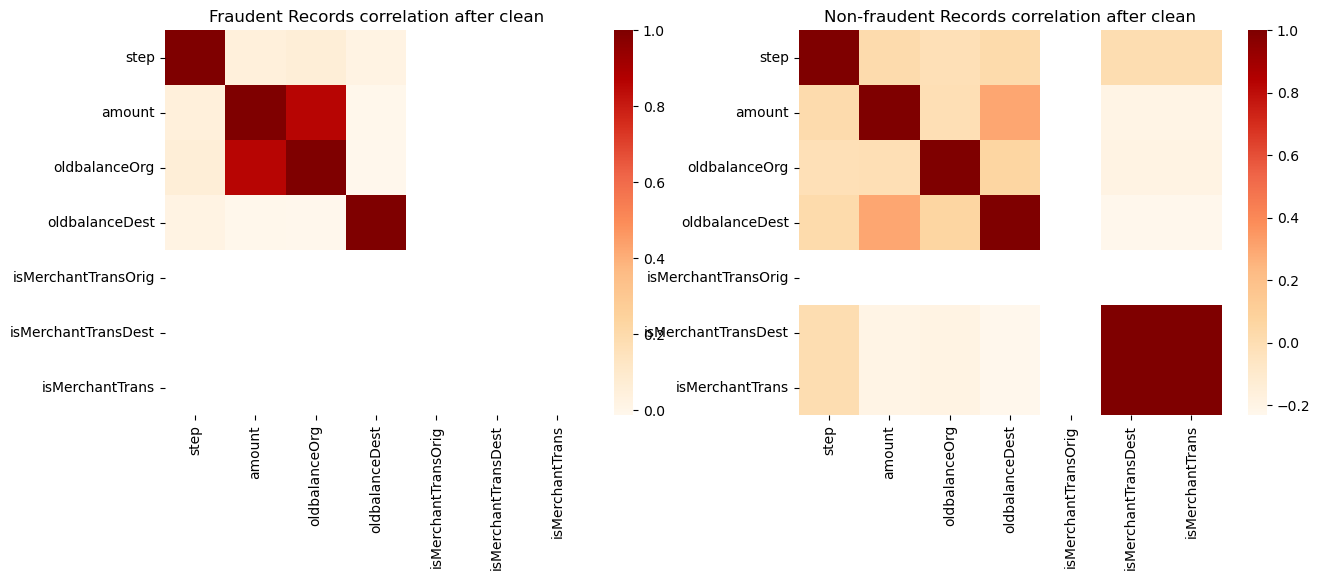

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Fraudulent records after clean
fraud_df = data_clean.query('isFraud == 1').drop(['isFraud'], axis=1)
fraud_corr = fraud_df.select_dtypes(include='number').corr()
ax[0].set_title("Fraudent Records correlation after clean")
if not fraud_corr.empty:
    sns.heatmap(fraud_corr, cmap="OrRd", ax=ax[0])
else:
    ax[0].text(0.5, 0.5, 'No data', ha='center', va='center')

# Non-fraudulent records after clean
nonfraud_df = data_clean.query('isFraud == 0').drop(['isFraud'], axis=1)
nonfraud_corr = nonfraud_df.select_dtypes(include='number').corr()
ax[1].set_title("Non-fraudent Records correlation after clean")
if not nonfraud_corr.empty:
    sns.heatmap(nonfraud_corr, cmap="OrRd", ax=ax[1])
else:
    ax[1].text(0.5, 0.5, 'No data', ha='center', va='center')

plt.show()

### Prepare dataset for SageMaker XGBoost

#### Column order - Labels in first column
Recorder columns such that the label is the first column. This is because of the format expected by XGBoost SageMaker implementation, for more details see https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

In [41]:
cols = data_clean.drop(["isFraud"], axis=1).columns.tolist()
cols.insert(0, "isFraud")
data_clean = data_clean[cols]
data_clean.head(n=5)

,isFraud,step,type,amount,nameOrig,oldbalanceOrg,nameDest,oldbalanceDest,isMerchantTransOrig,isMerchantTransDest,isMerchantTrans
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,M1979787155,0.0,0,1,1
1,0,1,PAYMENT,1864.28,C1666544295,21249.0,M2044282225,0.0,0,1,1
2,1,1,TRANSFER,181.00,C1305486145,181.0,C553264065,0.0,0,0,0
3,1,1,CASH_OUT,181.00,C840083671,181.0,C38997010,21182.0,0,0,0
4,0,1,PAYMENT,11668.14,C2048537720,41554.0,M1230701703,0.0,0,1,1


#### Unimportant non numerical column drop
XGBoost only works with numerical values, drop non-numerical columns source/des accounts 

In [43]:
data_clean = data_clean.drop([ 'nameOrig', 'nameDest'],axis=1)

#### Onehot encode categorical columns 
XG boost only works with numerical values, so translate categorical columns into one-hot vector

In [44]:
data_clean =  pd.get_dummies(data_clean,prefix=['transaction_type'],  columns=['type']) 
data_clean.head(n=5)

,isFraud,step,amount,oldbalanceOrg,oldbalanceDest,isMerchantTransOrig,isMerchantTransDest,isMerchantTrans,transaction_type_CASH_IN,transaction_type_CASH_OUT,transaction_type_DEBIT,transaction_type_PAYMENT,transaction_type_TRANSFER
0,0,1,9839.64,170136.0,0.0,0,1,1,False,False,False,True,False
1,0,1,1864.28,21249.0,0.0,0,1,1,False,False,False,True,False
2,1,1,181.00,181.0,0.0,0,0,0,False,False,False,False,True
3,1,1,181.00,181.0,21182.0,0,0,0,False,True,False,False,False
4,0,1,11668.14,41554.0,0.0,0,1,1,False,False,False,True,False


#### Train test set split
Split the dataset into train, test and validation set

In [45]:
from sklearn.model_selection import train_test_split, learning_curve

train_val, test = train_test_split(data_clean, test_size = 0.2, random_state = 777)
train, validation = train_test_split(train_val, test_size = 0.2, random_state = 777)

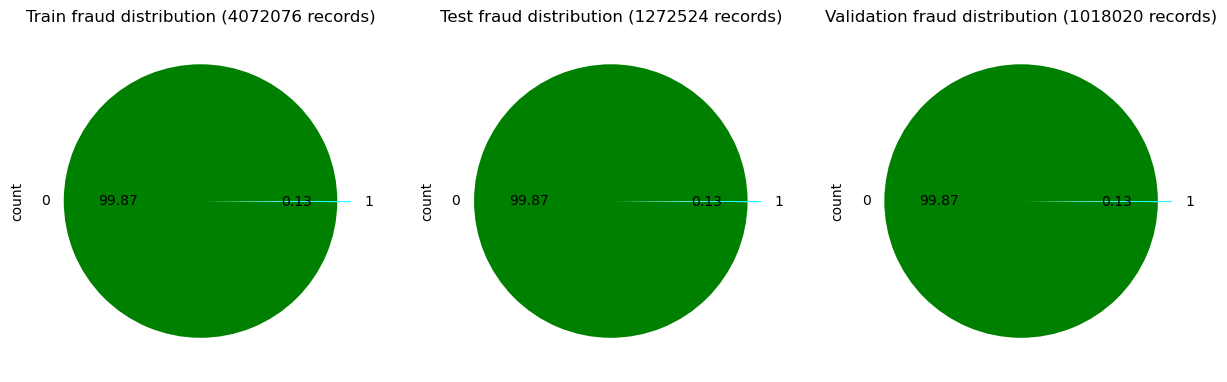

In [46]:
fig, ax = plt.subplots( 1,3, figsize=(15,5))

train.isFraud.value_counts().plot.pie(autopct='%.2f', ax = ax[0], colors=["green","cyan"], explode=[0,.1])
ax[0].set_title('Train fraud distribution ({} records)'.format(train.shape[0]))

test.isFraud.value_counts().plot.pie(autopct='%.2f', ax = ax[1], colors=["green","cyan"], explode=[0,.1])
ax[1].set_title('Test fraud distribution ({} records)'.format(test.shape[0]))

validation.isFraud.value_counts().plot.pie(autopct='%.2f', ax = ax[2], colors=["green","cyan"], explode=[0,.1])
ax[2].set_title('Validation fraud distribution ({} records)'.format(validation.shape[0]))

plt.show() 

In [52]:
import os

output_dir = "data/processed"
os.makedirs(output_dir, exist_ok=True)

trainfile = os.path.join(output_dir, "train_paysim.csv")
testfile = os.path.join(output_dir, "test_paysim.csv")
validationfile = os.path.join(output_dir, "validation_paysim.csv")

Write the records to file

In [53]:
train.to_csv(path_or_buf=trainfile, sep=',', na_rep='', header=False, index=False,  mode='w', encoding='UTF-8', quotechar='"', lineterminator='\n', decimal='.')
test.to_csv(path_or_buf=testfile, sep=',', na_rep='', header=False, index=False,  mode='w', encoding='UTF-8', quotechar='"', lineterminator='\n', decimal='.')
validation.to_csv(path_or_buf=validationfile, sep=',', na_rep='', header=False, index=False,  mode='w', encoding='UTF-8', quotechar='"', lineterminator='\n', decimal='.')

In [54]:
#!head $trainfile

Copy the data to s3 into train and test channels

In [58]:
#s3train="s3://{}/train/{}".format(bucket_prefix, "train.txt")
#s3validation="s3://{}/validation/{}".format(bucket_prefix, "validation.txt")

#print(trainfile)
#!aws s3 cp $trainfile $s3train
#!aws s3 cp $validationfile $s3validation



## Training the XGBoost model

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 5 and 6 minutes.


In [59]:
# Local XGBoost training (no SageMaker required)
import xgboost as xgb
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare data
X_train = train.drop('isFraud', axis=1)
y_train = train['isFraud']
X_val = validation.drop('isFraud', axis=1)
y_val = validation['isFraud']
X_test = test.drop('isFraud', axis=1)
y_test = test['isFraud']

# Train XGBoost model
model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    objective='binary:logistic',
    n_estimators=50,
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=777
 )
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Evaluate on test set
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

ap_score = average_precision_score(y_test, y_pred_proba)
print(f'AUC under precision recall curve (test set): {ap_score:.4f}')
print('Classification report:')
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

[0]	validation_0-aucpr:0.14626
[1]	validation_0-aucpr:0.06814
[1]	validation_0-aucpr:0.06814
[2]	validation_0-aucpr:0.00720
[2]	validation_0-aucpr:0.00720


/Users/carlychinsekyi/miniconda3/envs/mlops/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[3]	validation_0-aucpr:0.10466
[4]	validation_0-aucpr:0.01723
[4]	validation_0-aucpr:0.01723
[5]	validation_0-aucpr:0.03443
[5]	validation_0-aucpr:0.03443
[6]	validation_0-aucpr:0.01462
[6]	validation_0-aucpr:0.01462
[7]	validation_0-aucpr:0.01141
[7]	validation_0-aucpr:0.01141
[8]	validation_0-aucpr:0.01599
[8]	validation_0-aucpr:0.01599
[9]	validation_0-aucpr:0.05814
[9]	validation_0-aucpr:0.05814
[10]	validation_0-aucpr:0.04289
[10]	validation_0-aucpr:0.04289
[11]	validation_0-aucpr:0.05430
[11]	validation_0-aucpr:0.05430
[12]	validation_0-aucpr:0.03688
[12]	validation_0-aucpr:0.03688
[13]	validation_0-aucpr:0.08378
[13]	validation_0-aucpr:0.08378
[14]	validation_0-aucpr:0.09552
[14]	validation_0-aucpr:0.09552
[15]	validation_0-aucpr:0.10280
[15]	validation_0-aucpr:0.10280
[16]	validation_0-aucpr:0.13400
[16]	validation_0-aucpr:0.13400
[17]	validation_0-aucpr:0.11189
[17]	validation_0-aucpr:0.11189
[18]	validation_0-aucpr:0.13106
[18]	validation_0-aucpr:0.13106
[19]	validation_0-auc

In [66]:
#**Note:** SageMaker training job code has been removed. The notebook now uses local XGBoost training with scikit-learn and xgboost. See the previous cell for local model training and evaluation.

### Create Model

%%time
import boto3
from time import gmtime, strftime

model_name=job_name + '-model'
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

## Predict Using Batch transform

This is a good use of batch transform where you simply evalute the model  before deloying it as an API

In [69]:
import os
import numpy as np

# Use the same output directory as before
output_dir = "data/processed"
os.makedirs(output_dir, exist_ok=True)

batchfileinput = os.path.join(output_dir, "batchvalidation.csv")
batchfileresults = os.path.join(output_dir, "batchvalidation_results.csv")

# Prepare batch input: use validation set (excluding label)
X_batch = validation.drop('isFraud', axis=1)
X_batch.to_csv(batchfileinput, index=False, header=True)


In [73]:
# Local batch inference using trained XGBoost model
import pandas as pd

# Read batch input
X_batch = pd.read_csv(batchfileinput)

# Predict probabilities
batch_pred_proba = model.predict_proba(X_batch)[:, 1]

# Save predictions to CSV
pd.DataFrame(batch_pred_proba, columns=["predicted_proba"]).to_csv(batchfileresults, index=False)

print(f"Batch predictions saved to {batchfileresults}")

Batch predictions saved to data/processed/batchvalidation_results.csv


In [74]:
# Load batch predictions and print a sample
import pandas as pd

# Read the predicted probabilities from the local batch results file
batch_pred_proba = pd.read_csv(batchfileresults)["predicted_proba"].values

# Print a sample prediction
print(f"Sample batch prediction: {batch_pred_proba[0]}")

# For further evaluation, you can use batch_pred_proba as needed

Sample batch prediction: 1.0234446e-08


### Measurement using - AUCPR
Because the postive samples are underrepresented, measures such as AUC under ROC or accuracy inflate the numbers. So, use the AUC under the Precision Recall curve instead as it doesnt take into account True Negatives

In [76]:
import sklearn

# Use validation labels and local batch predictions
y_true = validation['isFraud'].values
predicted = batch_pred_proba  # from previous cell

micro_score = sklearn.metrics.average_precision_score(y_true, predicted, average='micro', sample_weight=None)
print(f"AUC under precision recall curve is {micro_score}")

AUC under precision recall curve is 0.3888419181770848


In [78]:
# Show a sample input and the model's prediction
import pandas as pd

# Select a random sample from the validation set
sample_idx = 0  # You can change this index to see other samples
sample_input = validation.drop('isFraud', axis=1).iloc[sample_idx]
sample_true_label = validation['isFraud'].iloc[sample_idx]

# Model prediction
sample_pred_proba = model.predict_proba([sample_input])[0, 1]
sample_pred_class = int(sample_pred_proba > 0.5)

print("Sample input features:\n", sample_input)
print(f"True label: {sample_true_label}")
print(f"Predicted probability of fraud: {sample_pred_proba:.4f}")
print(f"Predicted class: {sample_pred_class}")

Sample input features:
 step                                187
amount                         30982.46
oldbalanceOrg                4897720.44
oldbalanceDest                 36134.08
isMerchantTransOrig                   0
isMerchantTransDest                   0
isMerchantTrans                       0
transaction_type_CASH_IN           True
transaction_type_CASH_OUT         False
transaction_type_DEBIT            False
transaction_type_PAYMENT          False
transaction_type_TRANSFER         False
Name: 2254047, dtype: object
True label: 0
Predicted probability of fraud: 0.0000
Predicted class: 0
